# Tutorial: context aware learning of multiple modalities with mmcontext

## Contents of Tutorial

This tutorial demonstrates how to use the mmcontext package to preprocess single-cell data. We'll walk through the steps of:

**Preprocessing**:
1. Loading the Dataset
2. Generating Embeddings
3. Normalizing Embeddings
4. Aligning Embeddings
5. Constructing the Dataset
6. Creating a Data Loader

**Model fitting**:
1. Initialize the model
2. Configure the loss
3. Train the model

### Preprocessing
#### 1. Loading the Dataset

The input data has to be an {class}`anndata.AnnData` object. First, we'll load the example dataset provided in data/small_cellxgene.h5ad. It is derived from the cellxgene census {cite:p}`czi2023cz` and contains cells of various tissues and celltypes from different studys. The scvi embedding included is provided by cellxgene and contains embeddings computed with the scvi variational autoencoder trained on the cellxgene corpus. It is a custom made dataset that contains data from various tissues originating from different datasets.

In [1]:
# Import necessary libraries
import anndata
import scanpy as sc

data_path = "../../data/test_data/subset2_large_cellxgene.h5ad"
# Load the dataset
adata = anndata.read_h5ad(data_path)
# Display basic information about the dataset
# Log transformation for reconstruction
sc.pp.log1p(adata)
print(adata)

AnnData object with n_obs × n_vars = 10000 × 5000
    obs: 'soma_joinid', 'donor_id', 'disease', 'sex', 'dataset_id', 'cell_type', 'assay', 'tissue', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    uns: 'log1p'
    obsm: 'scvi'


In [9]:
from mmcontext.pp.utils import split_anndata, remove_entries, consolidate_low_frequency_categories

# split anndata into train and test
train_adata, test_adata = split_anndata(adata, train_size=0.8)
remove_entries(train_adata)
remove_entries(test_adata)
# remove cells with less than 10 appearances

train_adata = consolidate_low_frequency_categories(
    train_adata, columns=["cell_type", "dataset_id"], threshold=5, remove=True
)
# remove cells with less than 10 appearances
test_adata = consolidate_low_frequency_categories(
    test_adata, columns=["cell_type", "dataset_id"], threshold=5, remove=True
)

mmcontext.pp.utils - INFO - No cells with zero variance found.
mmcontext.pp.utils - INFO - No cells with zero variance found.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\scanpy\preprocessing\_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\scanpy\preprocessing\_simple.py:167: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


#### 2. Generate Embeddings

We will generate context embeddings based on the categorical metadata fields cell_type and tissue using the {class}`mmcontext.pp.CategoryEmbedder` class.
The method is based on creating an embedding of the individual categories of a cell with a text model. The `embeddings_file_path` points to a dictionary that contains embeddings for a range of cell types and tissues from the cellxgene corpus, thereby allowing the method to work without needing an API call. Only if some categories are not found in the dictionary the api will be used. If only a few are unknown, these will just be filled with a zero embedding. The `unkown_threshold` parameter controls how many new categories are needed to use the API. For that of course an API Key will be needed, which has to be set as an environmental variable "OPENAI_API_KEY". 

We will use the precomputed data embeddings stored in `adata.obsm['scvi']` as our data embeddings

In [10]:
# Import the CategoryEmbedder class
from mmcontext.pp import CategoryEmbedder, Embedder

# Specify the categories to embed
categories = ["cell_type"]
one_hot = False
# Initialize the CategoryEmbedder
category_embedder = CategoryEmbedder(
    metadata_categories=categories,
    model="text-embedding-3-small",
    combination_method="concatenate",
    embeddings_file_path="../../data/emb_dicts/category_embeddings_text-embedding-3-small_metadata_embeddings.pkl.gz",
    one_hot=one_hot,
)
# Initialize the Embedder without embedders
embedder = Embedder(context_embedder=category_embedder, data_embedder=None)

# Create embeddings using external embeddings
for adata in [train_adata, test_adata]:
    embedder.create_embeddings(adata, data_embeddings=adata.obsm["scvi"])
    # Confirm the shape of the context embeddings
    print("Context Embeddings Shape:", adata.obsm["c_emb"].shape)
    print("Data Embeddings Shape:", adata.obsm["d_emb"].shape)

mmcontext.pp.context_embedder - INFO - Loaded embeddings from file.
mmcontext.pp.context_embedder - INFO - Embeddings dictionary contains the following categories: dict_keys(['cell_type', 'tissue', 'assay']) with a total of 947 elements.
mmcontext.pp.embedder - INFO - Using external data embeddings provided.
mmcontext.pp.embedder - INFO - Creating context embeddings...
mmcontext.pp.context_embedder - INFO - Embeddings for 'cell_type' stored in adata.obsm['cell_type_emb']
mmcontext.pp.context_embedder - INFO - Combined context embeddings stored in adata.obsm['c_emb']
Context Embeddings Shape: (7842, 1536)
Data Embeddings Shape: (7842, 50)
mmcontext.pp.embedder - INFO - Using external data embeddings provided.
mmcontext.pp.embedder - INFO - Creating context embeddings...
mmcontext.pp.context_embedder - INFO - Embeddings for 'cell_type' stored in adata.obsm['cell_type_emb']
mmcontext.pp.context_embedder - INFO - Combined context embeddings stored in adata.obsm['c_emb']
Context Embeddings 

#### 3. Normalize Embeddings 

Now that the embeddings are created and stored in the adata object we can apply normalization. We will use the {class}`mmcontext.pp.MinMaxNormalizer` here. 

In [11]:
# Import the MinMaxNormalizer class
from mmcontext.pp import MinMaxNormalizer

# Initialize the MinMaxNormalizer
normalizer = MinMaxNormalizer()
# Normalize the embeddings
for adata in [train_adata, test_adata]:
    normalizer.normalize(adata)

    # Confirm that normalized embeddings are stored
    print("Normalized Data Embeddings Shape:", adata.obsm["d_emb_norm"].shape)
    print("Normalized Context Embeddings Shape:", adata.obsm["c_emb_norm"].shape)

mmcontext.pp.embedding_normalizer - INFO - Normalizing embeddings using min-max normalization...
Normalized Data Embeddings Shape: (7842, 50)
Normalized Context Embeddings Shape: (7842, 1536)
mmcontext.pp.embedding_normalizer - INFO - Normalizing embeddings using min-max normalization...
Normalized Data Embeddings Shape: (1798, 50)
Normalized Context Embeddings Shape: (1798, 1536)


#### 4. Aligning Embeddings

After normalization we will now use a {class}`mmcontext.pp.DimAligner` to make sure the dimensions of both data and context embeddings are equal, as this will be nescessary for the model. We will use the {class}`mmcontext.pp.PCAReducer` for this. If embeddings are larger than target latent dimension, they will be reduced via PCA. If there are smaller, padding with zeros will be applied. If using the {class}`mmcontext.pp.PCAReducer`, you can evaluate the principal components with some plots and metrics.

In [12]:
from omegaconf import DictConfig

# Create a DictConfig object for the configuration
config = DictConfig(
    {
        "evaluate_pca": True,
        "save_path": "pca_eval_oh",
        "scree_plot": True,
        "cumulative_variance_plot": True,
        "loadings_heatmap": True,
        "loadings_heatmap_options": {
            "threshold": 0,  # Only include loadings above this threshold
            "top_n_components": 64,  # Number of principal components to include in the heatmap
            "top_n_variables": 1000,  # Number of variables to display in the heatmap
        },
    }
)
# Configuration dictionary for PCA evaluation

if config.evaluate_pca and one_hot:
    config.one_hot_order = adata.uns["one_hot_order"]

In [13]:
# Import the PCAReducer class
from mmcontext.pp import PCAReducer

# Initialize the PCAReducer with the desired latent dimension
latent_dim = 64
aligner = PCAReducer(latent_dim=latent_dim, config=config)

# Align the embeddings
for adata in [train_adata, test_adata]:
    aligner.align(adata)

    # Confirm that aligned embeddings are stored
    print("Aligned Data Embeddings Shape:", adata.obsm["d_emb_aligned"].shape)
    print("Aligned Context Embeddings Shape:", adata.obsm["c_emb_aligned"].shape)

mmcontext.pp.dim_aligner - INFO - one_hot_order not provided. Using default feature indices.
mmcontext.pp.dim_aligner - INFO - Applied threshold: 0
mmcontext.pp.dim_aligner - INFO - Selected top 1000 variables based on importance.
mmcontext.pp.dim_aligner - INFO - Loadings heatmap saved to pca_eval_oh\loadings_heatmap.png
mmcontext.pp.dim_aligner - INFO - Loadings heatmap generation complete.
Aligned Data Embeddings Shape: (7842, 64)
Aligned Context Embeddings Shape: (7842, 64)
mmcontext.pp.dim_aligner - INFO - one_hot_order not provided. Using default feature indices.
mmcontext.pp.dim_aligner - INFO - Applied threshold: 0
mmcontext.pp.dim_aligner - INFO - Selected top 1000 variables based on importance.
mmcontext.pp.dim_aligner - INFO - Loadings heatmap saved to pca_eval_oh\loadings_heatmap.png
mmcontext.pp.dim_aligner - INFO - Loadings heatmap generation complete.
Aligned Data Embeddings Shape: (1798, 64)
Aligned Context Embeddings Shape: (1798, 64)


#### 5. Constructing the Dataset

Finally, we will construct a dataset using the aligned embeddings, suitable for training models with PyTorch.

In [14]:
# Import the DataSetConstructor class
from mmcontext.pp import DataSetConstructor

# Initialize the DataSetConstructor
train_dataset_constructor = DataSetConstructor(in_sample_id_key="soma_joinid")
test_dataset_constructor = DataSetConstructor(in_sample_id_key="soma_joinid")

# Add the AnnData object to the dataset
train_dataset_constructor.add_anndata(train_adata)
test_dataset_constructor.add_anndata(test_adata)

# The sequence length for the dataset. Since attention mechanisms will be used, samples can be grouped into sequences to perform attention within the sequence.
seq_length = 24
# Construct the dataset
train_dataset = train_dataset_constructor.construct_dataset(seq_length=seq_length)
test_dataset = test_dataset_constructor.construct_dataset(seq_length=seq_length)

#### 6. Create a Dataloader
Create a pyTorch Dataloader which can be iterated over

In [15]:
from torch.utils.data import DataLoader

# Create DataLoader
batch_size = 16  # Number of sequences per batch
if batch_size * seq_length > train_adata.n_obs:
    raise ValueError("Batch size and sequence length are too large for the dataset.")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# For now use the test data as validation data
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Iterate over DataLoader and verify batch shapes
for batch in train_loader:
    data_embeddings = batch["data_embedding"]  # Shape: (batch_size, seq_length, embedding_dim)
    context_embeddings = batch["context_embedding"]  # Shape: (batch_size, seq_length, embedding_dim)
    sample_ids = batch["sample_id"]  # Shape: (batch_size, seq_length)
    raw_data = batch["raw_data"]  # Shape: (batch_size, seq_length, num_features)

    print(data_embeddings.shape)
    print(context_embeddings.shape)
    print(sample_ids.shape)
    print(raw_data.shape)
    break  # Only need to check the first batch

torch.Size([16, 24, 64])
torch.Size([16, 24, 64])
torch.Size([16, 24])
torch.Size([16, 24, 5000])


### Model fitting
#### 1. Initializing the Model
The {class} `mmcontext.engine.MMContextEncoder` is the main encoder which will be used to create embeddings based on the available data and context embeddings. It's structure is flexible and is build upon torchs {class} `torch.nn.TransformerEncoder` which creates stacks of the {class} `mmcontext.engine.CustomTransformerEncoderLayer` which can be configured to be 

1. An MLP only model
2. To apply self attention (use_self_attention = True)
3. To apply cross attention (use_cross_attention = True)
4. To use both self and cross attention (both True)

The model takes two matrix inputs, `in_main` and `in_cross`. in_main will be passed through the MLP and optionally the self-attention layers, while in_cross is only used if cross-attention is used. In the end the model outputs embeddings of the same shape as in_main, updated based on the learning objective. The inputs are handled in the {class} `mmcontext.engine.Trainer` in dependancy with the settings used for the loss. 

In [16]:
from mmcontext.engine import MMContextEncoder, ZINBDecoder

hidden_dim = 64
num_layers = 2
num_heads = 1
encoder = MMContextEncoder(
    embedding_dim=latent_dim,  # this has to be the same dimension as the latent dimension of the aligner
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    use_self_attention=False,
    use_cross_attention=False,
    activation="relu",
    dropout=0.1,
)
decoder = ZINBDecoder(
    input_dim=latent_dim,
    hidden_dims=[64, 128],
    output_dim=train_adata.shape[1],  # number of genes
)

mmcontext.engine.models - INFO - MMContextEncoder initialized with embedding_dim = 64, num_layers = 2, use_self_attention = False, use_cross_attention = False.
ZINBDecoder
mmcontext.engine.models - INFO - ZINBDecoder initialized with input_dim = 64, hidden_dims = [64, 128], output_dim = 5000.


#### 2. Configure the loss
The loss function is a central part of this project. The loss is implemented to be extendable and customizable by having a {class} `mmcontext.engine.LossManager` which you can use to add different losses to and which will be passed to the {class} `mmcontext.engine.Trainer` to compute the total loss (as a weighted average of the components) during Training. The current main implementation of a {class} `mmcontext.engine.LossFunction` is the {class} `mmcontext.engine.ContrastiveLoss`, which is a custom approach to contrastive learning. It's main configuration parameters are `target_mode` and `current_mode` which refer to the way in which the target similarity matrix and the current (during model training) similarity matrix are constructed. For example if `target_mode = 'context_context'`, the original context embeddings are used to create the target similarity matrix. Therefore during training, the loss is calcualted as the mean squared error between the current similarity matrix and the one based on the context. If `current_mode = 'data_data'`, the model would learn to find representations of the data that represent similarity found in the respective context.  

In [17]:
from mmcontext.engine import LossManager, ContrastiveLoss, ZINBLoss

loss_manager = LossManager()
loss_manager.add_loss(ContrastiveLoss(target_mode="infoNCE", current_mode="data_context", similarity_metric="cosine"))
loss_manager.add_loss(ZINBLoss(), weight=0.01)

mmcontext.engine.losses - INFO - Adding loss function: ContrastiveLoss(target_mode=infoNCE, current_mode=data_context, similarity_metric=cosine) with weight 1.00
mmcontext.engine.losses - INFO - Adding loss function: ZINBLoss with weight 0.01


#### 3. Train the Model
The Trainer uses the defined model and loss the conduct training, aiming to iterativly minimize the loss. The {func} `mmcontext.engine.Trainer.fit` method can take a training and a validation dataloader as input. If a validation loader is given and a save_path is used, the weights of the best performing model can be saved to file. The {class} `mmcontext.engine.MMContextEncoder` has a method `load` to load weights from file.
Per default data embeddings are used for in_main while context embeddings are used as in_cross.

In [19]:
from mmcontext.engine import Trainer
import torch

model_parameters = list(encoder.parameters()) + list(decoder.parameters())
trainer = Trainer(
    encoder=encoder,
    decoder=decoder,
    loss_manager=loss_manager,
    optimizer=torch.optim.Adam(model_parameters),
    input_embeddings={"main": "data_embedding", "cross": "context_embedding"},
    temperature=0.07,
)
trainer.fit(train_loader, val_loader, epochs=10, save=True)

mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 1/10
mmcontext.engine.trainer - INFO - Batch 10/21, Loss: 13.0921
mmcontext.engine.trainer - INFO - Batch 20/21, Loss: 12.6689
mmcontext.engine.trainer - INFO - Batch 21/21, Loss: 11.1183
mmcontext.engine.trainer - INFO - Training Epoch Complete. Average Loss: 13.1645
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 13.2320
mmcontext.engine.trainer - INFO - Epoch 1/10 - Train Loss: 13.1645, Val Loss: 13.2320
mmcontext.engine.models - INFO - Saving model state dictionary to encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder weights saved in current working dir.
mmcontext.engine.models - INFO - Saving model state dictionary to decoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Decoder weights saved in current working dir.
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO

In [21]:
import numpy as np

# add a little bit of noise to the test data because otherwise hvg selection evaluation has a problem with the same values
test_adata2 = test_adata.copy()
test_adata2.X += np.random.normal(0, 1e-10, size=test_adata2.X.shape)
# The fitted model can be used to create universial embeddings
encoder.load(file_path="encoder_weights.pth")
decoder.load(file_path="decoder_weights.pth")
trainer = Trainer(
    encoder=encoder, decoder=decoder, input_embeddings={"main": "data_embedding", "cross": "context_embedding"}
)
inferred_adata = trainer.infer_adata(
    test_adata, sample_id_key="soma_joinid", seq_length=seq_length, batch_size=batch_size
)

mmcontext.engine.models - INFO - Placeholder model initialized.
mmcontext.engine.models - INFO - Loading model state dictionary from encoder_weights.pth
mmcontext.engine.models - INFO - Loading model state dictionary from decoder_weights.pth
mmcontext.engine.trainer - WARNING - Removing 22 samples not found in inference outputs. Most likely because could not be processed due to seq_length.


#### 4. Evaluate the embeddings
In order to assess the quality of the embeddings, the {class}`mmcontext.eval.scibEvaluator` can be used. It computes metrics from the scib package {cite:p}`luecken2022benchmarking` in order to asess bioconservation and batch integration. This can also be judged visualy with a umap.

In [ ]:
from mmcontext.pl.plotting import plot_umap
from mmcontext.eval import scibEvaluator

# Initialize scibEvaluator
evaluator = scibEvaluator(
    adata=inferred_adata, batch_key="dataset_id", label_key="cell_type", embedding_key=["scvi", "mod_emb"]
)

res = evaluator.evaluate()
res

mmcontext.eval.evaluate - INFO - Computing metrics on raw data...
mmcontext.eval.evaluate - INFO - Computing PCA on all genes...


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


resolution: 0.1, nmi: 0.3293711507797154
resolution: 0.2, nmi: 0.3293711507797154
resolution: 0.3, nmi: 0.3293711507797154
resolution: 0.4, nmi: 0.4795330382730887
resolution: 0.5, nmi: 0.4795330382730887
resolution: 0.6, nmi: 0.4795330382730887
resolution: 0.7, nmi: 0.6092357055770896
resolution: 0.8, nmi: 0.6092357055770896
resolution: 0.9, nmi: 0.6092357055770896
resolution: 1.0, nmi: 0.6559107204643948
resolution: 1.1, nmi: 0.6559107204643948
resolution: 1.2, nmi: 0.6559107204643948
resolution: 1.3, nmi: 0.6861939945239306
resolution: 1.4, nmi: 0.6861939945239306
resolution: 1.5, nmi: 0.7300118074053852
resolution: 1.6, nmi: 0.7300118074053852
resolution: 1.7, nmi: 0.760870712617925
resolution: 1.8, nmi: 0.760870712617925
resolution: 1.9, nmi: 0.760870712617925
resolution: 2.0, nmi: 0.760870712617925
optimised clustering against cell_type
optimal cluster resolution: 1.7
optimal score: 0.760870712617925
isolated labels: no more than 1 batches per label
CD4-positive, alpha-beta T cel

C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_6mwt5mld'>
  _warnings.warn(warn_message, ResourceWarning)


mmcontext.eval.evaluate - INFO - Computing metrics on reconstructed data...
mmcontext.eval.evaluate - INFO - Computing PCA on all reconstructed genes...
resolution: 0.1, nmi: 0.0
resolution: 0.2, nmi: 0.2860078188389118
resolution: 0.3, nmi: 0.2860078188389118
resolution: 0.4, nmi: 0.2860078188389118
resolution: 0.5, nmi: 0.2737525061311563
resolution: 0.6, nmi: 0.4138666910928781
resolution: 0.7, nmi: 0.42684474796581107
resolution: 0.8, nmi: 0.4130391048174443
resolution: 0.9, nmi: 0.48479799682065694
resolution: 1.0, nmi: 0.48479799682065694
resolution: 1.1, nmi: 0.45897115259294846
resolution: 1.2, nmi: 0.4632660839190144
resolution: 1.3, nmi: 0.4786750008759192


C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_cvnabqmm'>
  _warnings.warn(warn_message, ResourceWarning)


resolution: 1.4, nmi: 0.4805805603017399
resolution: 1.5, nmi: 0.4805805603017399
resolution: 1.6, nmi: 0.47241046235479006
resolution: 1.7, nmi: 0.4661585876307101
resolution: 1.8, nmi: 0.4736012226156637
resolution: 1.9, nmi: 0.47173240885153306
resolution: 2.0, nmi: 0.47173240885153306
optimised clustering against cell_type
optimal cluster resolution: 0.9
optimal score: 0.48479799682065694
isolated labels: no more than 1 batches per label
CD4-positive, alpha-beta T cell: 0.4360586404800415
CD8-positive, alpha-beta T cell: 0.5
GABAergic amacrine cell: 0.45063334703445435
Mueller cell: 0.39282405376434326
Purkinje cell: 0.43860679864883423
fibroblast: 0.5873469114303589
glycinergic amacrine cell: 0.49028608202934265
neoplastic cell: 0.36538153886795044
neural cell: 0.43442589044570923
isolated labels: no more than 1 batches per label
Compute neighbors on rep X_pca
CD4-positive, alpha-beta T cell: 0.36363636363636365
Compute neighbors on rep X_pca
CD8-positive, alpha-beta T cell: 0.222

C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_5vquowk3'>
  _warnings.warn(warn_message, ResourceWarning)


mmcontext.eval.evaluate - ERROR - Error computing iLISI on reconstructed data: [WinError 193] %1 ist keine zulässige Win32-Anwendung


C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_fzszp4mj'>
  _warnings.warn(warn_message, ResourceWarning)


mmcontext.eval.evaluate - INFO - Computing metrics on embedding 'scvi'...
resolution: 0.1, nmi: 0.0
resolution: 0.2, nmi: 0.3959959032358296
resolution: 0.3, nmi: 0.5638957001258951
resolution: 0.4, nmi: 0.5638957001258951
resolution: 0.5, nmi: 0.6510887968956285
resolution: 0.6, nmi: 0.6160852082691831
resolution: 0.7, nmi: 0.6160852082691831
resolution: 0.8, nmi: 0.6432169096070618
resolution: 0.9, nmi: 0.6823619724493021
resolution: 1.0, nmi: 0.7599943654063518
resolution: 1.1, nmi: 0.7599943654063518
resolution: 1.2, nmi: 0.7599943654063518
resolution: 1.3, nmi: 0.7599943654063518
resolution: 1.4, nmi: 0.7557858680395916
resolution: 1.5, nmi: 0.7557858680395916
resolution: 1.6, nmi: 0.7557858680395916
resolution: 1.7, nmi: 0.7557858680395916
resolution: 1.8, nmi: 0.7381241398183829
resolution: 1.9, nmi: 0.7381241398183829
resolution: 2.0, nmi: 0.7381241398183829
optimised clustering against cell_type
optimal cluster resolution: 1.0
optimal score: 0.7599943654063518
isolated labels:

C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_ogl4gt19'>
  _warnings.warn(warn_message, ResourceWarning)
C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_k2ufrt0b'>
  _warnings.warn(warn_message, ResourceWarning)


Variance contribution increased after integration!
Setting PCR comparison score to 0.
mmcontext.eval.evaluate - INFO - Computing metrics on embedding 'mod_emb'...
resolution: 0.1, nmi: 0.0
resolution: 0.2, nmi: 0.0
resolution: 0.3, nmi: 0.4022968361917006
resolution: 0.4, nmi: 0.5822678793061282
resolution: 0.5, nmi: 0.5822678793061282
resolution: 0.6, nmi: 0.6485868667670929
resolution: 0.7, nmi: 0.6485868667670929
resolution: 0.8, nmi: 0.6739440565630954
resolution: 0.9, nmi: 0.6753834350192776
resolution: 1.0, nmi: 0.7082371212059251
resolution: 1.1, nmi: 0.7082371212059251
resolution: 1.2, nmi: 0.7135031241257289
resolution: 1.3, nmi: 0.740058967952156
resolution: 1.4, nmi: 0.7398554843440213
resolution: 1.5, nmi: 0.7398554843440213
resolution: 1.6, nmi: 0.7398554843440213
resolution: 1.7, nmi: 0.7383683075728278
resolution: 1.8, nmi: 0.7383683075728278
resolution: 1.9, nmi: 0.7383683075728278
resolution: 2.0, nmi: 0.7261530681273465
optimised clustering against cell_type
optimal c

C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_rru1hrnb'>
  _warnings.warn(warn_message, ResourceWarning)


mmcontext.eval.evaluate - ERROR - Error computing iLISI on embedding 'mod_emb': [WinError 193] %1 ist keine zulässige Win32-Anwendung


C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_3ec9hn5u'>
  _warnings.warn(warn_message, ResourceWarning)


Variance contribution increased after integration!
Setting PCR comparison score to 0.


We can also compare the reconstructed matrix and the original matrix. We do this by computing a variety of data properties and comparing them between orignal and reconstructed data

In [ ]:
from mmcontext.eval import compare_data_properties

# Assuming data1 and data2 are numpy arrays with your datasets
properties = compare_data_properties(
    inferred_adata.X.toarray(), inferred_adata.layers["reconstructed"], predefined_subset="all"
)

mmcontext.eval.data_properties - INFO - Using all available data properties.


C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:345: RuntimeWarning: invalid value encountered in divide
  cpm = (mtx / lib_sizes) * 1e6
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:753: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_res, _ = scipy.stats.spearmanr(mtx_sub, axis=0)
C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:411: RuntimeWarning: invalid value encountered in divide
  cpm = (mtx / lib_sizes) * 1e6
C:\Users\mengerj\repos\mmcontext\sr

mmcontext.eval.data_properties - INFO - Using all available data properties.
mmcontext.eval.data_properties - ERROR - Error computing bimodalityColCorr: 'float' object has no attribute 'flatten'


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\numpy\lib\_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:411: RuntimeWarning: invalid value encountered in divide
  cpm = (mtx / lib_sizes) * 1e6
C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:508: RuntimeWarning: Mean of empty slice
  return np.nanmean(cpm, axis=0)
C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:345: RuntimeWarning: invalid value encountered in divide
  cpm = (mtx / lib_sizes) * 1e6
C:\Users\mengerj\repos\mmcontext\src\mmcontext\eval\data_properties.py:484: RuntimeWarning: Mean of empty slice
  r

In [87]:
res

,data_id,hvg,type,ARI,NMI,ASW,Isolated_Labels_ASW,Isolated_Labels_F1,Bio_Conservation_Score,Graph_Connectivity,Silhouette_Batch,Batch_Integration_Score,Overall_Score,PCR
0,,None,raw,0.559837,0.760871,0.441567,0.538255,0.602714,0.580649,0.940816,0.540577,0.740697,0.644668,NaN
1,,None,reconstructed,0.263984,0.484798,0.435447,0.455063,0.366284,0.401115,0.917460,0.571853,0.738523,0.536078,0.726255
2,,None,embedding_scvi,0.523728,0.759994,0.541122,0.564910,0.498447,0.577640,0.969388,0.761023,0.576804,0.577306,0.000000
3,,None,embedding_mod_emb,0.541179,0.740059,0.556575,0.573461,0.582600,0.598775,0.969388,0.743789,0.571059,0.587688,0.000000


mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<Figure size 800x800 with 0 Axes>

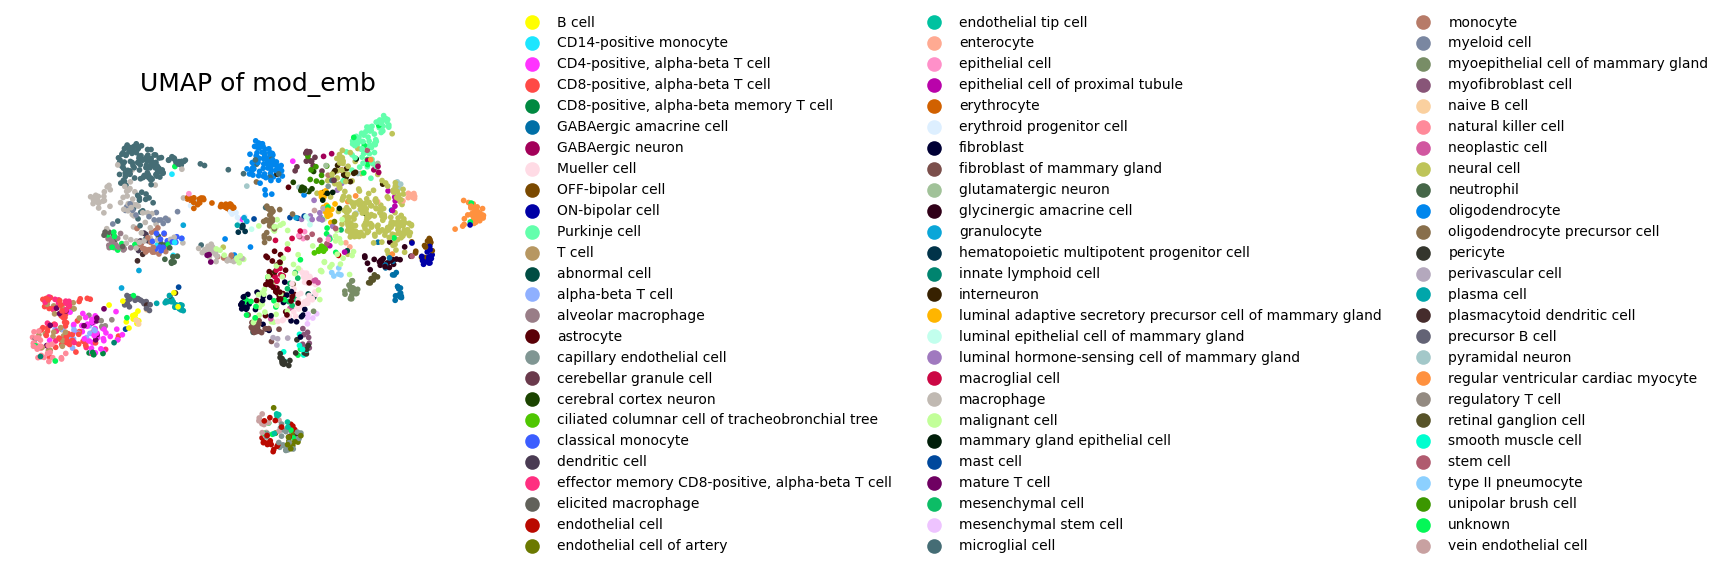

mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [31]:
plot_umap(inferred_adata, color_group="cell_type", embedding_key="mod_emb", save_plot=False)

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.


<Figure size 800x800 with 0 Axes>

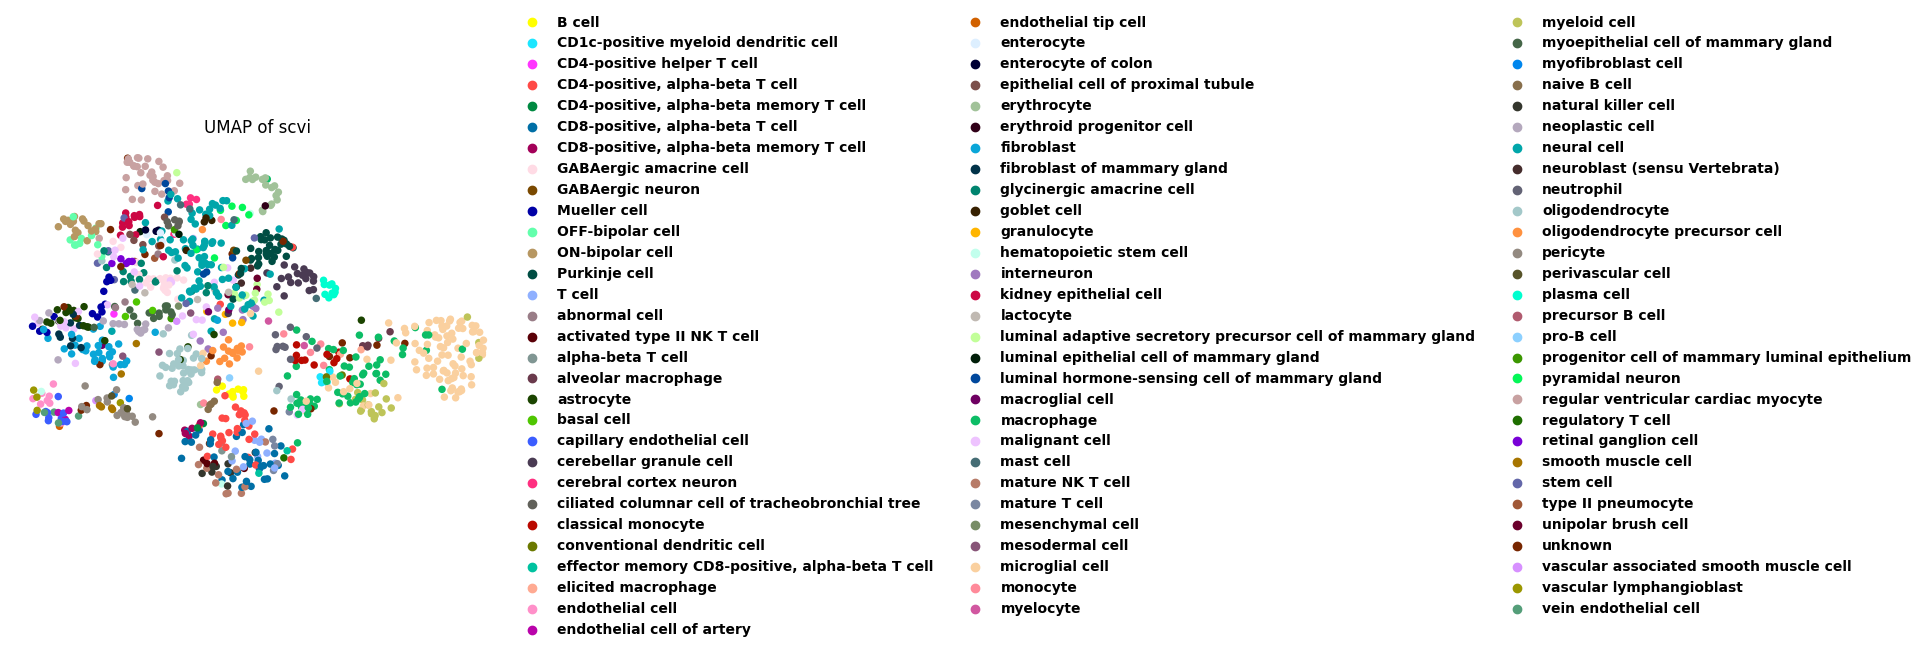

root - INFO - Displayed UMAP plot interactively.


In [19]:
plot_umap(inferred_adata, color_group="cell_type", embedding_key="scvi", save_plot=False)